# **Estimación de dirección de arribo de fuentes sonoras**



## 1.   En primera instancia, se instalan y se importan las librerias a utilizar.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.signal import correlate
import pyroomacoustics as pra
import soundfile as sf
from IPython.display import Audio
from scipy.fft import fft, ifft
from scipy.signal import correlate

import doascripts as doa
import simscripts as sim
import plotting as pt
import measuring as meas

## 2. Simulación del entorno acústico

Como primer acercamiento, se lleva a cabo la simulación de una habitación. Para realizar este proceso, se importa audio anecóico.

In [5]:
signal, fs = sf.read("Audios/imp.wav") # Importo audio e imprimo su Frecuencia de muestreo
print(f"Frecuencia de muestreo: {fs} Hz")

#signal = signal/np.max(signal)

Frecuencia de muestreo: 48000 Hz


Se plantean las características de la habitación, la posición de los micrófonos y de la fuente. Para esta primera simulación se considera que la sala simulada será anecóica.

In [6]:
# Se calculan posiciones de los micrófonos
mic_amount = 4
mic_start = [.1, .1, .1]
mic_dist = 0.1

mic_pos = sim.mic_array(mic_amount, mic_start, mic_dist)

# Se simula la sala
room_dim = [1, 1, 1]
source_position = [.5, .5, .5]
rt60 = 0.5

room = sim.room_sim(room_dim, rt60, mic_pos, source_position, signal, fs)

Se crea gráfico con posición de los elementos.

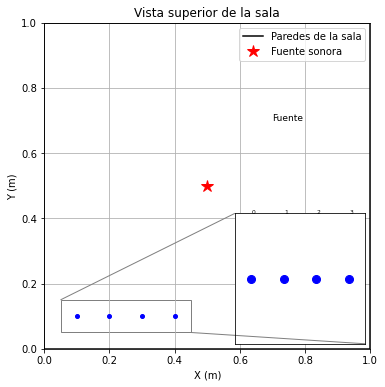

In [7]:
pt.plot_room_top_view(room_dim, mic_pos, source_position, zoom_margin=0.05)

Se confirma que el audio se haya simulado correctamente en la habitación, escuchando el audio resultante.

In [8]:
# señales grabadas por los micrófonos

mic_signals = room.mic_array.signals

print(np.shape(mic_signals))

Audio(room.mic_array.signals[1], rate=fs)


(4, 130004)


## 3. Estimación de TDOA (Time Difference of Arrival)

Se aplica para cada par de micrófonos y se grafica lo que capta un solo par, además de su correlación cruzada.

In [9]:
sig1 = mic_signals[0]  # señal del micrófono 1
sig2 = mic_signals[1]  # señal del micrófono 2

lag, corr = doa.gcc(sig1, sig2, fs, norm=True)

t = np.arange(len(sig1))/fs

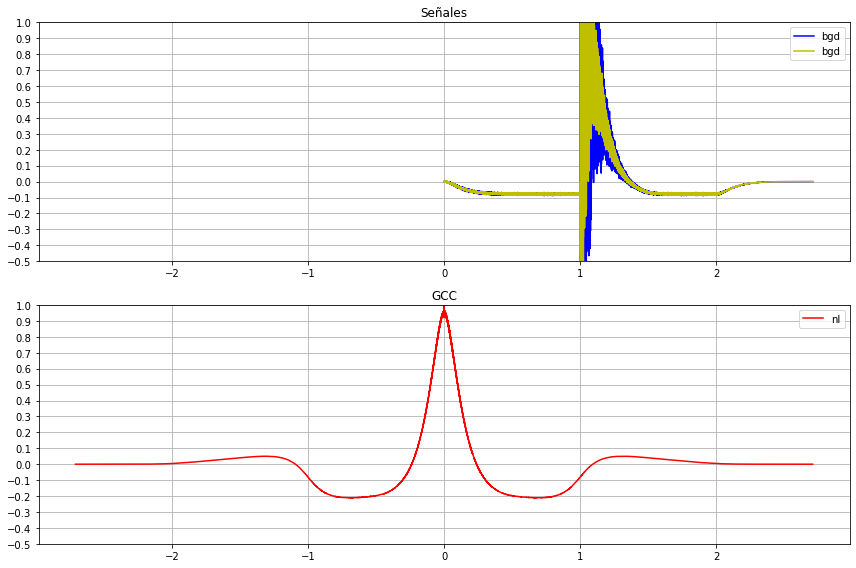

In [10]:
pt.plot_signals((t, sig1, 1, "Señales", "b", "bgd", None),
                (t, sig2, 1, "Señales", "y", "bgd", None),
                 (lag, corr, 2, "GCC", "r", "nl", None), grid=True, size=(12,8), ylim=[-.5,1], ybase=.1)

Se plantean los valores de TDOA entre cada par de micrófonos.

In [11]:
#tdoa_01 = td.gcc_tdoa(mic_signals[0], mic_signals[1], fs,'classic', None)

#doa_12 = td.gcc_tdoa(mic_signals[1], mic_signals[2], fs,'classic', None)

#tdoa_23 = td.gcc_tdoa(mic_signals[2], mic_signals[3], fs,'classic', None)

tdoas = doa.gcc_tdoas((mic_signals), fs)


print(tdoas)


[2.0833333333333333e-05, 2.0833333333333333e-05, 0.0]


## 4. Cálculo del ángulo de llegada (DOA)

Se sabe que la diferencia de tiempo de arribo entre micrófonos ante un frente de onda plano está dado por:

\begin{equation}
    \tau = \frac{d \cdot \cos(\theta)}{c}
\end{equation}



Despejando el ángulo de incidencia, se estima el ángulo de llegada final, promediando los medidos en cada par de micrófonos. Para esto se utilizaran las tdoa obtenidas por el metodo clasico.

In [12]:
doa_final = doa.doa([tdoa_01, tdoa_12, tdoa_23], mic_pos)


print(str(round(doa_final, 2)) + "°")
#print(str((doa_final)))

NameError: name 'tdoa_01' is not defined

---------------------------------------------------------------------------------------


In [15]:

dicc_base = {
    "room_dim": [10, 10, 10], 
    "rt60": 0.5,
    "mic_amount": 4,
    "mic_start": [1, 1, 1],
    "mic_dist": 0.1,
    "source_pos": [5, 5, 1],
    "fs": 44100}
    

sim.expand_param(dicc_base, "rt60", 0.05, filename = "x")

{'room_dim': [10, 10, 10],
 'rt60': [0.5,
  0.55,
  0.6,
  0.65,
  0.7,
  0.75,
  0.8,
  0.8500000000000001,
  0.9,
  0.95,
  1.0,
  1.05,
  1.1,
  1.15,
  1.2000000000000002,
  1.25,
  1.3,
  1.35,
  1.4,
  1.4500000000000002,
  1.5,
  1.55,
  1.6,
  1.6500000000000001,
  1.7000000000000002,
  1.75,
  1.8,
  1.85,
  1.9000000000000001,
  1.9500000000000002,
  2.0,
  2.05,
  2.1,
  2.1500000000000004,
  2.2,
  2.25,
  2.3,
  2.35,
  2.4000000000000004,
  2.45,
  2.5,
  2.5500000000000003,
  2.6,
  2.65,
  2.7,
  2.75,
  2.8000000000000003,
  2.85,
  2.9000000000000004,
  2.95],
 'mic_amount': 4,
 'mic_start': [1, 1, 1],
 'mic_dist': 0.1,
 'source_pos': [5, 5, 1],
 'fs': 44100}

In [ ]:
doa.full_doa_pipeline("x.json","Audios\imp.wav",)